<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2025/Wavelet_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Denoising an image usin Wavelets

PyWavelets library, discrete wavelet transform

In [1]:
import skimage
from skimage.transform import resize

In [2]:
!pip install -U PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.2 MB/s eta 0:00:00


In [3]:
import pywt

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

In [5]:
rng = np.random.default_rng(42)  # init random for repetability

# Image data

In [6]:
#exemple of images in the
#clean = skimage.data.camera()
#print(clean.shape,clean.max(),clean.dtype)

In [7]:

# here is the Peppers image that one can find in the github repo
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
import os
os.chdir("/content/drive/My Drive/Data4CoursSMallat")

In [9]:
from PIL import Image,ImageFilter
import numpy as np

im_frame = Image.open('peppers_512x512_8bits.png')
im_frame =im_frame.filter(filter=ImageFilter.BLUR)
clean = np.array(im_frame.getdata()).reshape((512,512)).astype(np.uint8)
image_max = clean.max()

In [10]:
clean.shape, clean.dtype,clean.max()

((512, 512), dtype('uint8'), np.uint8(222))

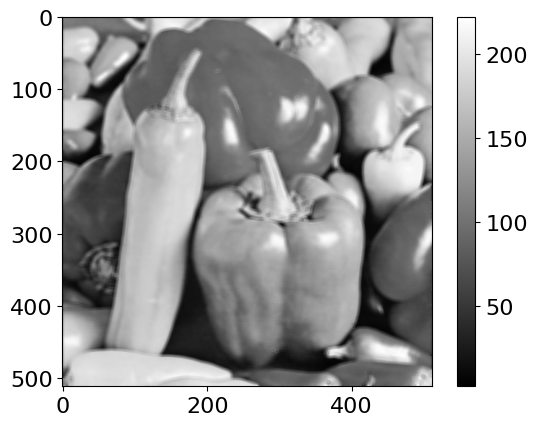

In [11]:
plt.imshow(clean,cmap='gray')
plt.colorbar();

# Single step wavelet transform

In [12]:
coeffs = pywt.dwt2(clean, 'db2', mode='periodization')
cA, (cH, cV, cD) = coeffs     # approx, horizontal, vertical, diagonal details
coeffs1 = pywt.dwt2(cA, 'db2', mode='periodization')
cA1, (cH1, cV1, cD1) = coeffs1

In [13]:
approx_imgs = [clean,cA,cA1]
titles=["Original","Approx-1","Approx-2"]

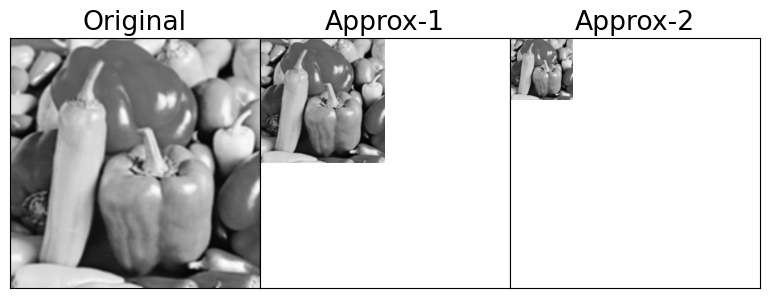

In [14]:
n_imgs = len(approx_imgs)
fig, axs=plt.subplots(1,n_imgs,figsize=(5*n_imgs,5),sharex=True, sharey=False)
for i in range(n_imgs):
  axs[i].imshow(approx_imgs[i],cmap='gray')
  axs[i].set_title(titles[i])
for ax in axs:
  ax.set_xlim([0, clean.shape[0]])
  ax.set_ylim([0, clean.shape[1]])
  ax.set_xticks([])
  ax.set_yticks([])
  ax.invert_yaxis()
  #ax.set_frame_on(False)
plt.subplots_adjust(left=0, bottom=None, right=0.5, top=None, wspace=0, hspace=0)



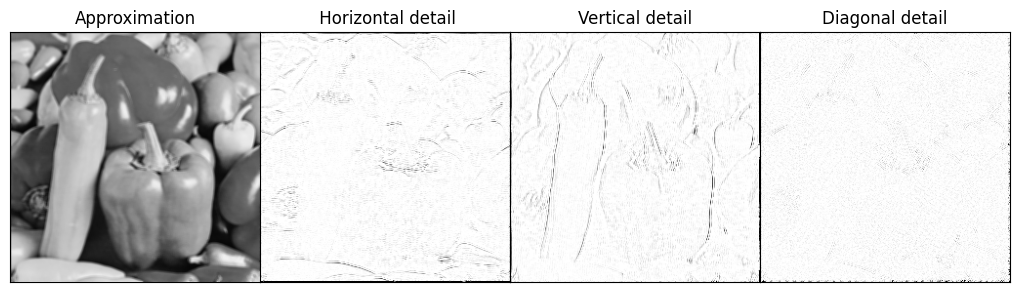

In [15]:
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
fig = plt.figure(figsize=(5*4,4))
for i, a in enumerate([cA, cH, cV, cD]):
    ax = fig.add_subplot(1, 4, i + 1)
    a = a/np.max(np.abs(a))
#    print(a.min(),a.max())
    vmin=0. if i>0 else 0
    vmax=0.2 if i>0 else 1
    im=ax.imshow(a,vmin=vmin,vmax=vmax,cmap='gray_r' if i>0 else 'gray')
    #plt.colorbar(im,ax=ax)
    ax.set_title(titles[i], fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(left=0, bottom=None, right=0.5, top=None, wspace=0, hspace=0)

# Denoising

In [16]:
def psnr(sig,ref,image_max=255):
  c = np.nanmean((sig-ref)**2)
  return 10*np.log10(image_max**2/c)

In [29]:
sigma_corrupt = 0.145*image_max  #18dB
noise = rng.normal(scale=sigma_corrupt, size=clean.shape)
noisy = clean+noise

In [30]:
psnr(noisy,clean)

np.float64(17.991700483150716)

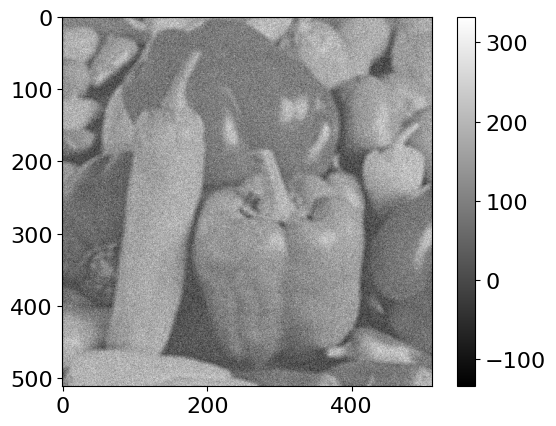

In [31]:
plt.imshow(noisy,cmap='gray')
plt.colorbar();

In [32]:
def Energy(x):
  return np.dot(x, x)


def mad(x):
  """! Estimates the Median Absolute Deviation (MAD). MAD is defined to be
  the median of the absolute difference between the input X and median(X).
  """
  return 1.482579 * np.median(np.abs(x - np.median(x)))


def UniversalThreshold(signal, sig_factor=1.0):
  """! Universal threshold  Donoho & Johnstone
  """
  m = signal.size # -> 1D & 2D
  sd = mad(signal) * sig_factor
  thr = sd * np.sqrt(2 * np.log(m))
  return thr

def SteinThreshold(signal):
  """! An implementation of Stein's unbiased rist estimator (SURE)
  inspired by Mathematica
  """
  m = signal.size  # -> 1D & 2D
  _signal = signal.flatten()    # for 2D
  sorted_signal = np.sort(_signal**2)
  c = np.linspace(m-1, 0, m)
  s = np.cumsum(sorted_signal) + c * sorted_signal
  risk = (m - (2.0 * np.arange(m)) + s)
  ibest = np.argmin(risk)
  thr = np.sqrt(sorted_signal[ibest])
  return thr

class Denoising:
    """! Denoising class
    wavelet: name of wavelet (pywt.wavelist(kind='discrete'))
    level: up to which level to apply wavelet decomposition, 0 is max
    thr_mode: type of threshold [hard]/soft
    thr_lbl :if True means thr defined for each level
    pad_mode: print(pywt.Modes.modes)
    """
    def __init__(self,
                 wavelet='haar',
                 level=1,
                 thr_mode='hard',
                 thr_lbl= True,
                 pad_mode='zero',
                 method='universal',
                 factor_univ=1.0
                 ):

        self.wavelet = wavelet
        self.level = level
        self.method = method
        self.thr_mode = thr_mode
        self.thr_lbl = thr_lbl
        self.pad_mode = pad_mode
        self.factor_univ = factor_univ

        self.filter_ = pywt.Wavelet(self.wavelet)    # Wavelet function

        # Check if level is None and set it to 1
        if level is None:
            self.nlevel = 1
        else:
            self.nlevel = level

    def fit(self, signal):
      """
      denoising processing
      """
      _signal = signal.copy()


      # decomposition
      if self.nlevel == 0:
          level = pywt.dwt_max_level(_signal.shape[0],
                                  filter_len=self.filter_.dec_len)
          self.nlevel = level

      coeffs = pywt.wavedec2(_signal, self.filter_, level=self.nlevel,
                            mode=self.pad_mode)

      coeffs, coeff_slices = pywt.coeffs_to_array(coeffs)

      dcoeffs = coeffs[1:] # details coeffs
      # thresholding
      if self.thr_lbl:
        # compute threshold at all levels of details and apply accordingly
        thr = [self.DetermineThreshold(np.asarray(level),self.factor_univ)  for level in dcoeffs]

        denoised_detail = [
            pywt.threshold(level, value=thresh, mode=self.thr_mode)
              for thresh, level in zip(thr, dcoeffs)
        ]

      else:
        if self.method == 'universal':
          # compute threshold with detail coefficients at first refinement
          # the length to be considered is the signal length
          data1 = np.asanyarray(coeffs[1])
          thr = self.DetermineThreshold(data1,self.factor_univ)\
                      * np.sqrt(np.log(_signal.size)/np.log(data1.size))
          #print("thr",thr)
          denoised_detail = [
              pywt.threshold(level, value=thr, mode=self.thr_mode)
                  for level in dcoeffs
          ]
        else:
          # compute threshold with detail coefficients at first refinement
          #print("taill D1:",len(coeffs[1]))
          data1 = np.asanyarray(coeffs[1])
          thr = self.DetermineThreshold(data1,self.factor_univ)
          #print("thr",thr)
          # apply at all levels of details
          denoised_detail = [
              pywt.threshold(level, value=thr, mode=self.thr_mode)
                for level in dcoeffs
          ]

      # filter
      coeffs[1:]=denoised_detail
      coeffs = pywt.array_to_coeffs(coeffs, coeff_slices, output_format='wavedec2')

      denoised_signal = pywt.waverec2(coeffs, self.filter_, mode=self.pad_mode)


      return denoised_signal,  self.nlevel

    def DetermineThreshold(self, coeff, factor_univ=1.0):
        """! Determines the value of the threshold.
        - for some threshold applyied to all levels see the code of "fit"
        - 'universal' - The threshold is the sqrt(2*length(x))*mad
        - 'stein' - Stein's unbiased risk estimator
        - 'energy' - Computes the energy of the coefficients and retains a
        predefined percentage of it.

        default method is the 'universal' method.
        """
        thr = 0.0
        if self.method == 'universal':
            thr = UniversalThreshold(coeff, factor_univ)
        elif self.method == 'stein':
            thr = SteinThreshold(coeff)
        else:
            print("No such method detected!")
            print("Set back to default (universal thresholding)!")
            thr = UniversalThreshold(coeff, factor_univ)
        return thr


In [33]:
# What is the best choice?

thr_modes=['hard','hard', 'soft','soft']
methods=4*['universal']
thr_lbls=4*[False]
factor_univs=[1.0,0.4,1.0,0.2]

best_psnr=-1
best_filtered=None
best_method=None
for wave_name in ["db1","db2",'db4','sym4']:
  for level_max in [2,3]:
    for i in range(len(methods)):
      wd = Denoising(wavelet=wave_name,
                level=level_max,
                thr_mode=thr_modes[i],
                method=methods[i],
                thr_lbl = thr_lbls[i],
                factor_univ = factor_univs[i]
                )

      denoised_signal, lvl_max  = wd.fit(noisy)
      psnr_cur = psnr(denoised_signal,clean)
      if psnr_cur>best_psnr:
        best_psnr=psnr_cur
        best_filtered = denoised_signal
        best_method = wave_name+ ":" + methods[i]
        if thr_modes[i] is not None:
          best_method += "/"+thr_modes[i]+"/"
        if thr_lbls[i]:
          best_method += "lv by lv"
        else:
          best_method += "all lv"
        best_method += f" lvl_max:{lvl_max}"

      print(wave_name,methods[i],"----" if thr_modes[i] is None else thr_modes[i],",lv by lv," if thr_lbls[i]  else ",  all lv,",
          f"({lvl_max})",factor_univs[i],f"PSNR:{psnr_cur:.2f}")

db1 universal hard ,  all lv, (2) 1.0 PSNR:21.61
db1 universal hard ,  all lv, (2) 0.4 PSNR:26.25
db1 universal soft ,  all lv, (2) 1.0 PSNR:12.14
db1 universal soft ,  all lv, (2) 0.2 PSNR:23.28
db1 universal hard ,  all lv, (3) 1.0 PSNR:25.18
db1 universal hard ,  all lv, (3) 0.4 PSNR:25.93
db1 universal soft ,  all lv, (3) 1.0 PSNR:18.52
db1 universal soft ,  all lv, (3) 0.2 PSNR:25.70
db2 universal hard ,  all lv, (2) 1.0 PSNR:22.61
db2 universal hard ,  all lv, (2) 0.4 PSNR:26.90
db2 universal soft ,  all lv, (2) 1.0 PSNR:12.78
db2 universal soft ,  all lv, (2) 0.2 PSNR:23.79
db2 universal hard ,  all lv, (3) 1.0 PSNR:27.51
db2 universal hard ,  all lv, (3) 0.4 PSNR:24.66
db2 universal soft ,  all lv, (3) 1.0 PSNR:19.67
db2 universal soft ,  all lv, (3) 0.2 PSNR:25.48
db4 universal hard ,  all lv, (2) 1.0 PSNR:18.09
db4 universal hard ,  all lv, (2) 0.4 PSNR:18.00
db4 universal soft ,  all lv, (2) 1.0 PSNR:21.01
db4 universal soft ,  all lv, (2) 0.2 PSNR:18.60
db4 universal hard ,

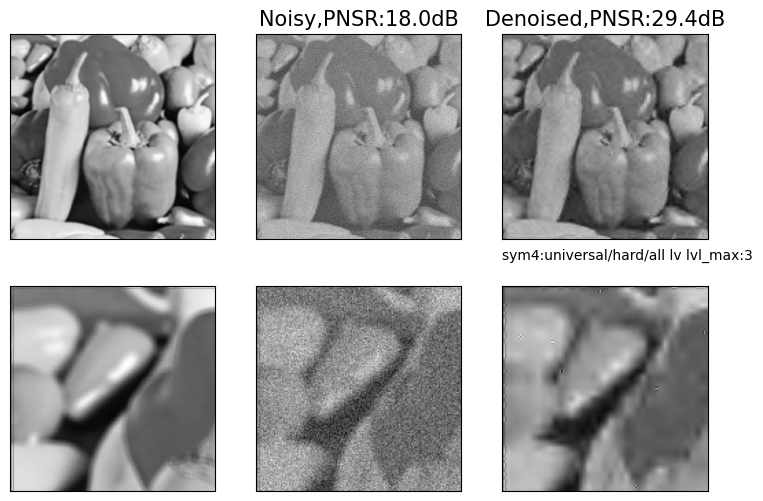

In [34]:
fig, axs=plt.subplots(2,3,figsize=(3*3,2*3))
imgs = [clean,noisy,best_filtered]
names=["Clean", "Noisy", "Denoised"]
psnr_all = [None, psnr(noisy,clean), best_psnr]
for i,img in enumerate(imgs):
  axs[0,i].imshow(img,cmap='gray')
  if names[i] != "Clean":
    axs[0,i].set_title(f'{names[i]},PNSR:{psnr_all[i]:.1f}dB',fontsize=15)
  axs[0,i].axes.xaxis.set_ticks([])
  axs[0,i].axes.yaxis.set_ticks([])
  axs[1,i].imshow(img[:150,:150],cmap='gray')
  axs[1,i].axes.xaxis.set_ticks([])
  axs[1,i].axes.yaxis.set_ticks([])

axs[0,2].text(0.,-0.1,best_method,
            backgroundcolor="white", transform=axs[0,2].transAxes,
            fontsize=10);


